In [4]:
import torch
from torch import optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

In [5]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [6]:
class TwoLayerCNN(nn.Module):

    def __init__(self, d):
        super(TwoLayerCNN, self).__init__()
        self.convl1 = nn.Sequential(         
            nn.Conv2d(1, 16, 5, 1, 2),                     
            nn.ReLU(),                      
            nn.MaxPool2d(2)    
        )
        self.convl2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2)                
        )
        self.layer = nn.Sequential(
            nn.Linear(32*7*7, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        x = self.convl1(x)
        x = self.convl2(x)
        x = x.view(x.size(0), -1)
        logits = self.layer(x)
        return logits

class FourLayerCNN(nn.Module):

    def __init__(self, d):
        super(FourLayerCNN, self).__init__()
        self.convl1 = nn.Sequential(         
            nn.Conv2d(1, 16, 5, 1, 2),                     
            nn.ReLU(),                      
            nn.MaxPool2d(2)    
        )
        self.convl2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2)                
        )
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*7*7, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        x = self.convl1(x)
        x = self.convl2(x)
        x = x.view(x.size(0), -1)
        logits = self.layer(x)
        return logits
    
class EightLayerCNN(nn.Module):

    def __init__(self, d):
        super(EightLayerCNN, self).__init__()
        self.convl1 = nn.Sequential(         
            nn.Conv2d(1, 16, 5, 1, 2),                     
            nn.ReLU(),                      
            nn.MaxPool2d(2)   
        )
        self.convl2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2)               
        )
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*7*7, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        x = self.convl1(x)
        x = self.convl2(x)
        x = x.view(x.size(0), -1)
        logits = self.layer(x)
        return logits

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [8]:
def train_epoch(dataloader, model, criterion, optimizer, regularizer):
    
    size = len(dataloader.dataset)
    
    for batchnum, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        yhat = model(X)
        loss = criterion(yhat, y)
        loss += regularizer(model)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batchnum % 100 == 0:
            loss, current = loss.item(), batchnum * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def validate(dataloader, model, criterion, regularizer):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            yhat = model(X)
            test_loss += criterion(yhat, y).item()
            correct += (yhat.argmax(1) == y).type(torch.float).sum().item()

    test_loss += regularizer(model)
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [9]:
def reg_WD(model):
    res = 0
    lmb = 1e-5
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res += (p**2).sum()
    return lmb*res

def weissi(model):
    res_e = 1
    res_c = 0
    lmb_e = 1e-6
    lmb_c = 1e-5
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res_e *= torch.linalg.norm(p)**2
            res_c += torch.sum(torch.linalg.norm(p/torch.linalg.norm(p,dim=(0,1)),1, dim=(0,1)))
    return lmb_e * torch.log(res_e) + lmb_c * res_c

def dropout_reg(model):
    return 0

def train(model, reg):
    lr = 1e-3
    batch_size = 128
    epochs = 20

    train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=1)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=1)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()
    
    accuracy = []

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        model.train()
        train_epoch(train_loader, model, criterion, optimizer, reg)
        model.eval()
        accuracy.append(validate(test_loader, model, criterion, reg))


    print("Done!")
    return accuracy
    

In [10]:
model = TwoLayerCNN(0).to(device)
twoLayerWD = train(model, reg_WD)

Epoch 1
-------------------------------
loss: 2.300518  [    0/60000]
loss: 0.631597  [12800/60000]
loss: 0.455178  [25600/60000]
loss: 0.441534  [38400/60000]
loss: 0.394658  [51200/60000]
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.398610 

Epoch 2
-------------------------------
loss: 0.409820  [    0/60000]
loss: 0.338176  [12800/60000]
loss: 0.346250  [25600/60000]
loss: 0.323605  [38400/60000]
loss: 0.225521  [51200/60000]
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.328760 

Epoch 3
-------------------------------
loss: 0.190552  [    0/60000]
loss: 0.285994  [12800/60000]
loss: 0.209345  [25600/60000]
loss: 0.274545  [38400/60000]
loss: 0.207223  [51200/60000]
Test Error: 
 Accuracy: 89.3%, Avg loss: 0.296136 

Epoch 4
-------------------------------
loss: 0.212643  [    0/60000]
loss: 0.267131  [12800/60000]
loss: 0.234431  [25600/60000]
loss: 0.253448  [38400/60000]
loss: 0.210410  [51200/60000]
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.270106 

Epoch 5
------------------------

In [11]:
model = TwoLayerCNN(0).to(device)
twoLayerWeissi = train(model, weissi)

Epoch 1
-------------------------------
loss: 2.304967  [    0/60000]
loss: 0.577524  [12800/60000]
loss: 0.501624  [25600/60000]
loss: 0.338842  [38400/60000]
loss: 0.289451  [51200/60000]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.395046 

Epoch 2
-------------------------------
loss: 0.404223  [    0/60000]
loss: 0.446180  [12800/60000]
loss: 0.296189  [25600/60000]
loss: 0.280023  [38400/60000]
loss: 0.307012  [51200/60000]
Test Error: 
 Accuracy: 87.8%, Avg loss: 0.323885 

Epoch 3
-------------------------------
loss: 0.370388  [    0/60000]
loss: 0.277585  [12800/60000]
loss: 0.311869  [25600/60000]
loss: 0.383054  [38400/60000]
loss: 0.233822  [51200/60000]
Test Error: 
 Accuracy: 89.5%, Avg loss: 0.291349 

Epoch 4
-------------------------------
loss: 0.211964  [    0/60000]
loss: 0.178944  [12800/60000]
loss: 0.356581  [25600/60000]
loss: 0.195200  [38400/60000]
loss: 0.218078  [51200/60000]
Test Error: 
 Accuracy: 89.8%, Avg loss: 0.274984 

Epoch 5
------------------------

In [12]:
model = TwoLayerCNN(0.25).to(device)
twoLayerDropout = train(model, dropout_reg)

Epoch 1
-------------------------------
loss: 2.311423  [    0/60000]
loss: 0.646583  [12800/60000]
loss: 0.514492  [25600/60000]
loss: 0.452463  [38400/60000]
loss: 0.400951  [51200/60000]
Test Error: 
 Accuracy: 85.9%, Avg loss: 0.394600 

Epoch 2
-------------------------------
loss: 0.312213  [    0/60000]
loss: 0.365778  [12800/60000]
loss: 0.324203  [25600/60000]
loss: 0.215687  [38400/60000]
loss: 0.480389  [51200/60000]
Test Error: 
 Accuracy: 88.3%, Avg loss: 0.324612 

Epoch 3
-------------------------------
loss: 0.321677  [    0/60000]
loss: 0.187578  [12800/60000]
loss: 0.237313  [25600/60000]
loss: 0.299410  [38400/60000]
loss: 0.260233  [51200/60000]
Test Error: 
 Accuracy: 89.2%, Avg loss: 0.296697 

Epoch 4
-------------------------------
loss: 0.273162  [    0/60000]
loss: 0.185994  [12800/60000]
loss: 0.187561  [25600/60000]
loss: 0.302777  [38400/60000]
loss: 0.323056  [51200/60000]
Test Error: 
 Accuracy: 89.0%, Avg loss: 0.312471 

Epoch 5
------------------------

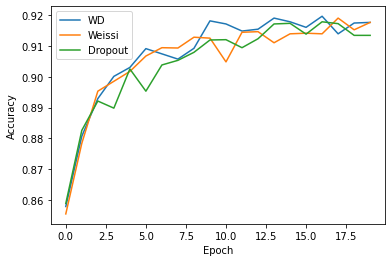

In [23]:

plt.plot(twoLayerWD,label="WD")
plt.plot(twoLayerWeissi,label="Weissi")
plt.plot(twoLayerDropout,label="Dropout")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [14]:
model = FourLayerCNN(0).to(device)
fourLayerWD = train(model, reg_WD)

Epoch 1
-------------------------------
loss: 2.306839  [    0/60000]
loss: 0.624737  [12800/60000]
loss: 0.522255  [25600/60000]
loss: 0.367001  [38400/60000]
loss: 0.450651  [51200/60000]
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.400389 

Epoch 2
-------------------------------
loss: 0.394910  [    0/60000]
loss: 0.408377  [12800/60000]
loss: 0.305068  [25600/60000]
loss: 0.252014  [38400/60000]
loss: 0.307333  [51200/60000]
Test Error: 
 Accuracy: 87.1%, Avg loss: 0.352274 

Epoch 3
-------------------------------
loss: 0.290786  [    0/60000]
loss: 0.336987  [12800/60000]
loss: 0.195240  [25600/60000]
loss: 0.254395  [38400/60000]
loss: 0.224316  [51200/60000]
Test Error: 
 Accuracy: 88.4%, Avg loss: 0.311414 

Epoch 4
-------------------------------
loss: 0.159318  [    0/60000]
loss: 0.245197  [12800/60000]
loss: 0.250321  [25600/60000]
loss: 0.216494  [38400/60000]
loss: 0.308001  [51200/60000]
Test Error: 
 Accuracy: 89.8%, Avg loss: 0.278617 

Epoch 5
------------------------

In [15]:
model = FourLayerCNN(0).to(device)
fourLayerWeissi = train(model, weissi)

Epoch 1
-------------------------------
loss: 2.298931  [    0/60000]
loss: 0.688693  [12800/60000]
loss: 0.606333  [25600/60000]
loss: 0.562973  [38400/60000]
loss: 0.368177  [51200/60000]
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.410357 

Epoch 2
-------------------------------
loss: 0.372575  [    0/60000]
loss: 0.434602  [12800/60000]
loss: 0.329700  [25600/60000]
loss: 0.379489  [38400/60000]
loss: 0.351293  [51200/60000]
Test Error: 
 Accuracy: 87.6%, Avg loss: 0.338122 

Epoch 3
-------------------------------
loss: 0.400435  [    0/60000]
loss: 0.320131  [12800/60000]
loss: 0.332439  [25600/60000]
loss: 0.346101  [38400/60000]
loss: 0.292395  [51200/60000]
Test Error: 
 Accuracy: 89.0%, Avg loss: 0.291855 

Epoch 4
-------------------------------
loss: 0.212310  [    0/60000]
loss: 0.331723  [12800/60000]
loss: 0.202264  [25600/60000]
loss: 0.344594  [38400/60000]
loss: 0.268395  [51200/60000]
Test Error: 
 Accuracy: 89.8%, Avg loss: 0.281781 

Epoch 5
------------------------

In [16]:
model = FourLayerCNN(0.25).to(device)
fourLayerDropout = train(model, dropout_reg)

Epoch 1
-------------------------------
loss: 2.308147  [    0/60000]
loss: 0.829345  [12800/60000]
loss: 0.584617  [25600/60000]
loss: 0.467753  [38400/60000]
loss: 0.356075  [51200/60000]
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.451987 

Epoch 2
-------------------------------
loss: 0.406801  [    0/60000]
loss: 0.546702  [12800/60000]
loss: 0.249405  [25600/60000]
loss: 0.306297  [38400/60000]
loss: 0.465272  [51200/60000]
Test Error: 
 Accuracy: 88.2%, Avg loss: 0.343093 

Epoch 3
-------------------------------
loss: 0.597432  [    0/60000]
loss: 0.270844  [12800/60000]
loss: 0.355498  [25600/60000]
loss: 0.302751  [38400/60000]
loss: 0.432982  [51200/60000]
Test Error: 
 Accuracy: 89.2%, Avg loss: 0.325775 

Epoch 4
-------------------------------
loss: 0.254249  [    0/60000]
loss: 0.306864  [12800/60000]
loss: 0.180792  [25600/60000]
loss: 0.347770  [38400/60000]
loss: 0.260851  [51200/60000]
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.309959 

Epoch 5
------------------------

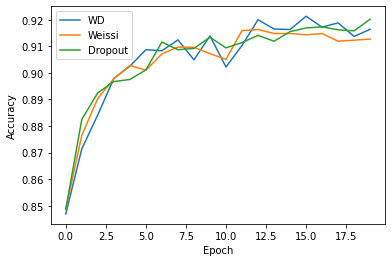

In [24]:

plt.plot(fourLayerWD,label="WD")
plt.plot(fourLayerWeissi,label="Weissi")
plt.plot(fourLayerDropout,label="Dropout")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [18]:
model = EightLayerCNN(0).to(device)
eightLayerWD = train(model, reg_WD)

Epoch 1
-------------------------------
loss: 2.310682  [    0/60000]
loss: 0.794881  [12800/60000]
loss: 0.683814  [25600/60000]
loss: 0.786923  [38400/60000]
loss: 0.481062  [51200/60000]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.578243 

Epoch 2
-------------------------------
loss: 0.558461  [    0/60000]
loss: 0.612454  [12800/60000]
loss: 0.568310  [25600/60000]
loss: 0.541243  [38400/60000]
loss: 0.409669  [51200/60000]
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.441680 

Epoch 3
-------------------------------
loss: 0.367034  [    0/60000]
loss: 0.437494  [12800/60000]
loss: 0.496129  [25600/60000]
loss: 0.431050  [38400/60000]
loss: 0.576982  [51200/60000]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.365893 

Epoch 4
-------------------------------
loss: 0.299517  [    0/60000]
loss: 0.385637  [12800/60000]
loss: 0.407985  [25600/60000]
loss: 0.214957  [38400/60000]
loss: 0.323823  [51200/60000]
Test Error: 
 Accuracy: 87.4%, Avg loss: 0.347680 

Epoch 5
------------------------

In [19]:
model = EightLayerCNN(0).to(device)
eightLayerWeissi = train(model, weissi)

Epoch 1
-------------------------------
loss: 2.304970  [    0/60000]
loss: 0.866566  [12800/60000]
loss: 0.709190  [25600/60000]
loss: 0.729505  [38400/60000]
loss: 0.629384  [51200/60000]
Test Error: 
 Accuracy: 79.6%, Avg loss: 0.566123 

Epoch 2
-------------------------------
loss: 0.685985  [    0/60000]
loss: 0.466089  [12800/60000]
loss: 0.447852  [25600/60000]
loss: 0.356744  [38400/60000]
loss: 0.483898  [51200/60000]
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.462938 

Epoch 3
-------------------------------
loss: 0.439870  [    0/60000]
loss: 0.384363  [12800/60000]
loss: 0.371668  [25600/60000]
loss: 0.335147  [38400/60000]
loss: 0.397708  [51200/60000]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.382704 

Epoch 4
-------------------------------
loss: 0.300463  [    0/60000]
loss: 0.287985  [12800/60000]
loss: 0.284122  [25600/60000]
loss: 0.288473  [38400/60000]
loss: 0.232738  [51200/60000]
Test Error: 
 Accuracy: 88.2%, Avg loss: 0.329095 

Epoch 5
------------------------

In [20]:
model = EightLayerCNN(0.25).to(device)
eightLayerDropout = train(model, dropout_reg)

Epoch 1
-------------------------------
loss: 2.304122  [    0/60000]
loss: 1.083898  [12800/60000]
loss: 0.925555  [25600/60000]
loss: 0.747099  [38400/60000]
loss: 0.606479  [51200/60000]
Test Error: 
 Accuracy: 73.7%, Avg loss: 0.685377 

Epoch 2
-------------------------------
loss: 0.617518  [    0/60000]
loss: 0.744559  [12800/60000]
loss: 0.650693  [25600/60000]
loss: 0.738991  [38400/60000]
loss: 0.678439  [51200/60000]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.561960 

Epoch 3
-------------------------------
loss: 0.468524  [    0/60000]
loss: 0.355354  [12800/60000]
loss: 0.696243  [25600/60000]
loss: 0.525791  [38400/60000]
loss: 0.485280  [51200/60000]
Test Error: 
 Accuracy: 82.8%, Avg loss: 0.499681 

Epoch 4
-------------------------------
loss: 0.540650  [    0/60000]
loss: 0.524771  [12800/60000]
loss: 0.511712  [25600/60000]
loss: 0.424017  [38400/60000]
loss: 0.412656  [51200/60000]
Test Error: 
 Accuracy: 83.0%, Avg loss: 0.523578 

Epoch 5
------------------------

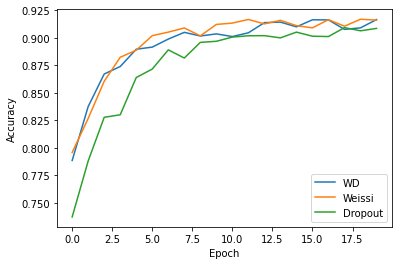

In [25]:

plt.plot(eightLayerWD,label="WD")
plt.plot(eightLayerWeissi,label="Weissi")
plt.plot(eightLayerDropout,label="Dropout")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [29]:
#Using the results from the 2layermlp, apply the same logic, but only change lmb_e by a factor of 1e1 and 1e-1
# lmb_e = 1e-5
# lmb_c = 1e-5
def weissi_1(model):
    res_e = 1
    res_c = 0
    lmb_e = 1e-5
    lmb_c = 1e-5
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res_e *= torch.linalg.norm(p)**2
            res_c += torch.sum(torch.linalg.norm(p/torch.linalg.norm(p,dim=(0,1)),1, dim=(0,1)))
    return lmb_e * torch.log(res_e) + lmb_c * res_c

# lmb_e = 1e-6
# lmb_c = 1e-5
def weissi_2(model):
    res_e = 1
    res_c = 0
    lmb_e = 1e-6
    lmb_c = 1e-5
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res_e *= torch.linalg.norm(p)**2
            res_c += torch.sum(torch.linalg.norm(p/torch.linalg.norm(p,dim=(0,1)),1, dim=(0,1)))
    return lmb_e * torch.log(res_e) + lmb_c * res_c

# lmb_e = 1e-7
# lmb_c = 1e-5
def weissi_3(model):
    res_e = 1
    res_c = 0
    lmb_e = 1e-7
    lmb_c = 1e-5
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res_e *= torch.linalg.norm(p)**2
            res_c += torch.sum(torch.linalg.norm(p/torch.linalg.norm(p,dim=(0,1)),1, dim=(0,1)))
    return lmb_e * torch.log(res_e) + lmb_c * res_c

In [30]:
model = EightLayerCNN(0).to(device)
eightLayerWeissi_1 = train(model, weissi_1)

Epoch 1
-------------------------------
loss: 2.298836  [    0/60000]
loss: 0.844219  [12800/60000]
loss: 0.782694  [25600/60000]
loss: 0.646649  [38400/60000]
loss: 0.489475  [51200/60000]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.579265 

Epoch 2
-------------------------------
loss: 0.611939  [    0/60000]
loss: 0.417226  [12800/60000]
loss: 0.533655  [25600/60000]
loss: 0.373646  [38400/60000]
loss: 0.478519  [51200/60000]
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.441137 

Epoch 3
-------------------------------
loss: 0.412701  [    0/60000]
loss: 0.400867  [12800/60000]
loss: 0.378336  [25600/60000]
loss: 0.219823  [38400/60000]
loss: 0.378210  [51200/60000]
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.416099 

Epoch 4
-------------------------------
loss: 0.342322  [    0/60000]
loss: 0.427928  [12800/60000]
loss: 0.302414  [25600/60000]
loss: 0.344552  [38400/60000]
loss: 0.238116  [51200/60000]
Test Error: 
 Accuracy: 88.3%, Avg loss: 0.329336 

Epoch 5
------------------------

In [31]:
model = EightLayerCNN(0).to(device)
eightLayerWeissi_2 = train(model, weissi_2)

Epoch 1
-------------------------------
loss: 2.304729  [    0/60000]
loss: 1.047036  [12800/60000]
loss: 0.634613  [25600/60000]
loss: 0.826380  [38400/60000]
loss: 0.523385  [51200/60000]
Test Error: 
 Accuracy: 79.6%, Avg loss: 0.542608 

Epoch 2
-------------------------------
loss: 0.635575  [    0/60000]
loss: 0.500887  [12800/60000]
loss: 0.516155  [25600/60000]
loss: 0.459572  [38400/60000]
loss: 0.384017  [51200/60000]
Test Error: 
 Accuracy: 83.7%, Avg loss: 0.458029 

Epoch 3
-------------------------------
loss: 0.350440  [    0/60000]
loss: 0.399297  [12800/60000]
loss: 0.272933  [25600/60000]
loss: 0.333077  [38400/60000]
loss: 0.289358  [51200/60000]
Test Error: 
 Accuracy: 87.5%, Avg loss: 0.380187 

Epoch 4
-------------------------------
loss: 0.471187  [    0/60000]
loss: 0.421689  [12800/60000]
loss: 0.225504  [25600/60000]
loss: 0.398422  [38400/60000]
loss: 0.219725  [51200/60000]
Test Error: 
 Accuracy: 87.7%, Avg loss: 0.367619 

Epoch 5
------------------------

In [34]:
model = EightLayerCNN(0).to(device)
eightLayerWeissi_3 = train(model, weissi_3)

Epoch 1
-------------------------------
loss: 2.305917  [    0/60000]
loss: 0.904405  [12800/60000]
loss: 0.670230  [25600/60000]
loss: 0.630066  [38400/60000]
loss: 0.490140  [51200/60000]
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.568711 

Epoch 2
-------------------------------
loss: 0.709718  [    0/60000]
loss: 0.478025  [12800/60000]
loss: 0.357011  [25600/60000]
loss: 0.404085  [38400/60000]
loss: 0.429984  [51200/60000]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.425770 

Epoch 3
-------------------------------
loss: 0.493650  [    0/60000]
loss: 0.335178  [12800/60000]
loss: 0.437164  [25600/60000]
loss: 0.318687  [38400/60000]
loss: 0.255520  [51200/60000]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.378624 

Epoch 4
-------------------------------
loss: 0.376119  [    0/60000]
loss: 0.336946  [12800/60000]
loss: 0.202410  [25600/60000]
loss: 0.295011  [38400/60000]
loss: 0.460891  [51200/60000]
Test Error: 
 Accuracy: 88.7%, Avg loss: 0.319443 

Epoch 5
------------------------

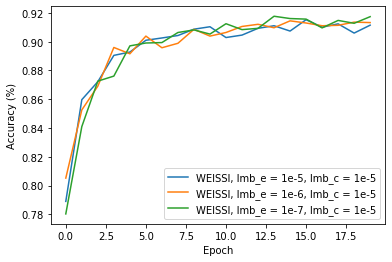

In [41]:
plt.plot(eightLayerWeissi_1,label="WEISSI, lmb_e = 1e-5, lmb_c = 1e-5")
plt.plot(eightLayerWeissi_2,label="WEISSI, lmb_e = 1e-6, lmb_c = 1e-5")
plt.plot(eightLayerWeissi_3,label="WEISSI, lmb_e = 1e-7, lmb_c = 1e-5")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

#lmb_e = 1e-6

In [36]:
#Using the results from the 2layermlp, apply the same logic, but only change lmb_e by a factor of 1e1 and 1e-1
# lmb_e = 1e-6
# lmb_c = 1e-4
def weissi_1(model):
    res_e = 1
    res_c = 0
    lmb_e = 1e-6
    lmb_c = 1e-4
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res_e *= torch.linalg.norm(p)**2
            res_c += torch.sum(torch.linalg.norm(p/torch.linalg.norm(p,dim=(0,1)),1, dim=(0,1)))
    return lmb_e * torch.log(res_e) + lmb_c * res_c

# lmb_e = 1e-6
# lmb_c = 1e-5
def weissi_2(model):
    res_e = 1
    res_c = 0
    lmb_e = 1e-6
    lmb_c = 1e-5
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res_e *= torch.linalg.norm(p)**2
            res_c += torch.sum(torch.linalg.norm(p/torch.linalg.norm(p,dim=(0,1)),1, dim=(0,1)))
    return lmb_e * torch.log(res_e) + lmb_c * res_c

# lmb_e = 1e-6
# lmb_c = 1e-6
def weissi_3(model):
    res_e = 1
    res_c = 0
    lmb_e = 1e-6
    lmb_c = 1e-6
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res_e *= torch.linalg.norm(p)**2
            res_c += torch.sum(torch.linalg.norm(p/torch.linalg.norm(p,dim=(0,1)),1, dim=(0,1)))
    return lmb_e * torch.log(res_e) + lmb_c * res_c

In [37]:
model = EightLayerCNN(0).to(device)
eightLayerWeissi_1 = train(model, weissi_1)

Epoch 1
-------------------------------
loss: 2.317421  [    0/60000]
loss: 1.009768  [12800/60000]
loss: 0.677465  [25600/60000]
loss: 0.641570  [38400/60000]
loss: 0.519578  [51200/60000]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.573533 

Epoch 2
-------------------------------
loss: 0.569826  [    0/60000]
loss: 0.549857  [12800/60000]
loss: 0.468771  [25600/60000]
loss: 0.443878  [38400/60000]
loss: 0.337656  [51200/60000]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.399110 

Epoch 3
-------------------------------
loss: 0.483652  [    0/60000]
loss: 0.393454  [12800/60000]
loss: 0.440900  [25600/60000]
loss: 0.388590  [38400/60000]
loss: 0.461288  [51200/60000]
Test Error: 
 Accuracy: 87.2%, Avg loss: 0.352747 

Epoch 4
-------------------------------
loss: 0.308785  [    0/60000]
loss: 0.329274  [12800/60000]
loss: 0.280231  [25600/60000]
loss: 0.242072  [38400/60000]
loss: 0.327395  [51200/60000]
Test Error: 
 Accuracy: 89.0%, Avg loss: 0.315540 

Epoch 5
------------------------

In [38]:
model = EightLayerCNN(0).to(device)
eightLayerWeissi_2 = train(model, weissi_2)

Epoch 1
-------------------------------
loss: 2.310178  [    0/60000]
loss: 0.924057  [12800/60000]
loss: 0.603278  [25600/60000]
loss: 0.493052  [38400/60000]
loss: 0.427984  [51200/60000]
Test Error: 
 Accuracy: 80.5%, Avg loss: 0.520342 

Epoch 2
-------------------------------
loss: 0.603934  [    0/60000]
loss: 0.513386  [12800/60000]
loss: 0.563294  [25600/60000]
loss: 0.355995  [38400/60000]
loss: 0.402420  [51200/60000]
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.406499 

Epoch 3
-------------------------------
loss: 0.371570  [    0/60000]
loss: 0.371746  [12800/60000]
loss: 0.438344  [25600/60000]
loss: 0.228316  [38400/60000]
loss: 0.299400  [51200/60000]
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.357340 

Epoch 4
-------------------------------
loss: 0.348827  [    0/60000]
loss: 0.328954  [12800/60000]
loss: 0.396752  [25600/60000]
loss: 0.274495  [38400/60000]
loss: 0.322958  [51200/60000]
Test Error: 
 Accuracy: 89.6%, Avg loss: 0.312791 

Epoch 5
------------------------

In [39]:
model = EightLayerCNN(0).to(device)
eightLayerWeissi_3 = train(model, weissi_3)

Epoch 1
-------------------------------
loss: 2.304400  [    0/60000]
loss: 0.843009  [12800/60000]
loss: 1.009195  [25600/60000]
loss: 0.781362  [38400/60000]
loss: 0.528252  [51200/60000]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.637618 

Epoch 2
-------------------------------
loss: 0.599709  [    0/60000]
loss: 0.739105  [12800/60000]
loss: 0.601712  [25600/60000]
loss: 0.395456  [38400/60000]
loss: 0.321601  [51200/60000]
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.448874 

Epoch 3
-------------------------------
loss: 0.301641  [    0/60000]
loss: 0.356917  [12800/60000]
loss: 0.447542  [25600/60000]
loss: 0.343977  [38400/60000]
loss: 0.329963  [51200/60000]
Test Error: 
 Accuracy: 87.3%, Avg loss: 0.371621 

Epoch 4
-------------------------------
loss: 0.261127  [    0/60000]
loss: 0.373696  [12800/60000]
loss: 0.338006  [25600/60000]
loss: 0.223937  [38400/60000]
loss: 0.261638  [51200/60000]
Test Error: 
 Accuracy: 87.6%, Avg loss: 0.336511 

Epoch 5
------------------------

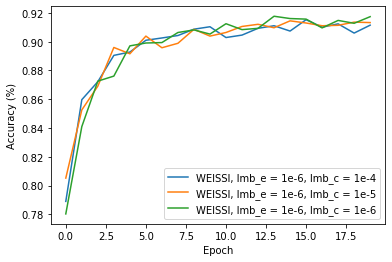

In [42]:
plt.plot(eightLayerWeissi_1,label="WEISSI, lmb_e = 1e-6, lmb_c = 1e-4")
plt.plot(eightLayerWeissi_2,label="WEISSI, lmb_e = 1e-6, lmb_c = 1e-5")
plt.plot(eightLayerWeissi_3,label="WEISSI, lmb_e = 1e-6, lmb_c = 1e-6")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

#lmb_e = 1e-6